In [2]:
# LOAD LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd

In [3]:
## load data
data = pd.read_csv('../data/output/final_database.csv')
data.columns

# date as datetime
data['Date'] = pd.to_datetime(data['Date'])
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data['day_of_week'] = data['Date'].dt.dayofweek

# Classical ridge regression using all the time series 

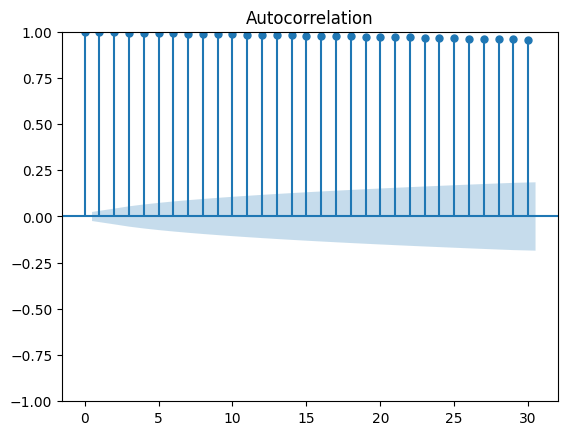

In [4]:
# ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['Close'], lags=30)
plt.show()

In [17]:
data_copy = data.copy()
for i in range(1, 6):
    data_copy['lag_' + str(i)] = data_copy['Close'].shift(i)

data_copy = data_copy.dropna()

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

feature_cols = [
                'GDPV', 'IRL', 'IRS', 'GDP', 'CPIH_YTYPCT', 'IRCB', 'UNR',
                'YPH', 'UNR_us',  'CPI_us', 'High_minus_Low', 'Close_minus_Open',
                'SMA_5', 'SMA_10', 'SMA_20', 'WMA_5', 'WMA_10', 'WMA_20', 'Momentum',
                'RSI', 'Williams_R', 'Stochastic_K', 'Stochastic_D', 'CCI', 'MACD',
                'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']

# Select only the columns in `feature_cols` for features
X = data_copy[feature_cols]

# Define the target variable
y = data_copy['Close'].copy()  # Adjust this if your target variable column is named differently
y = y

year = data_copy['Date'].dt.year

X_train =  scaler.fit_transform(X[year < 2023])
X_test = scaler.fit_transform(X[year >= 2023])

y_test = y[year >= 2023].reset_index(drop=True)
y_train = y[year < 2023].reset_index(drop=True)

In [35]:
# from sklearn.preprocessing import StandardScaler

# # Initialize the scaler
# scaler = StandardScaler()

# feature_cols = [
#                 'GDPV', 'IRL', 'IRS', 'GDP', 'CPIH_YTYPCT', 'IRCB', 'UNR',
#                 'YPH', 'UNR_us',  'CPI_us', 'High_minus_Low', 'Close_minus_Open',
#                 'SMA_5', 'SMA_10', 'SMA_20', 'WMA_5', 'WMA_10', 'WMA_20', 'Momentum',
#                 'RSI', 'Williams_R', 'Stochastic_K', 'Stochastic_D', 'CCI', 'MACD',]

# # Select features
# X = data[feature_cols]

# # Define the target variable
# y = data['Close'].copy()  # Ensure this matches the name of your target column

# # Extract the year for splitting data
# year = data['Date'].dt.year

# # Split the data into training and test sets
# X_train = X[year < 2023]
# X_test = X[year >= 2023]
# y_train = y[year < 2023]
# y_test = y[year >= 2023]

# # Fit the scaler on the training data and transform both train and test sets
# X_train= scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)  # Use transform here, not fit_transform

# # Optionally, scale the target variable if needed (not always recommended for regression tasks)
# scaler_y = StandardScaler()
# y_train= scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # Ensure correct shape for scaling
# y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

In [36]:
#Linear Regression
lambda_grid = np.logspace(-2, 4, 50)
ridge_cv = RidgeCV(alphas=lambda_grid,fit_intercept=True).fit(X_train, y_train) #to perform cross validation

In [37]:
X_train.shape

(4993, 5)

In [38]:
# Extract the best alpha (lambda) value
optimal_alpha = ridge_cv.alpha_
print(f"Optimal Alpha (Regularization Strength): {optimal_alpha}")

# Coefficients of the model
coefficients = ridge_cv.coef_
intercept = ridge_cv.intercept_

# Predictions on the train and test sets
y_train_pred = ridge_cv.predict(X_train)
y_test_pred = ridge_cv.predict(X_test)

# Performance metrics for the training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_r_squared = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = train_mse ** 0.5

# Performance metrics for the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_r_squared = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = test_mse ** 0.5

# Prepare the data for the summary table
summary_table = {
    "Metric": ["R²", "MSE", "RMSE", "MAE"],
    "Train": [train_r_squared, train_mse, train_rmse, train_mae],
    "Test": [test_r_squared, test_mse, test_rmse, test_mae]
}

summary_table = pd.DataFrame(summary_table)
print(summary_table)

Optimal Alpha (Regularization Strength): 10000.0
  Metric        Train         Test
0     R²     0.996606     0.965679
1    MSE  3364.301560  3894.022436
2   RMSE    58.002600    62.402103
3    MAE    40.517067    48.297979


As one can see, there is a significant difference between the training and test performance metrics. This is a clear indication that the model is overfitting the training data.

In [39]:
# Filter feature columns to exclude "Close"
filtered_features = [var for var in feature_cols if var != "Close"]

# Create a DataFrame for coefficients and variables
coef_df = pd.DataFrame({
    "Variable": feature_cols,
    "Coefficient": coefficients[0]
})

In [40]:
print(coef_df.sort_values(by="Coefficient", ascending=False))

  Variable  Coefficient
0    lag_1     0.970332
1    lag_2     0.970332
2    lag_3     0.970332
3    lag_4     0.970332
4    lag_5     0.970332


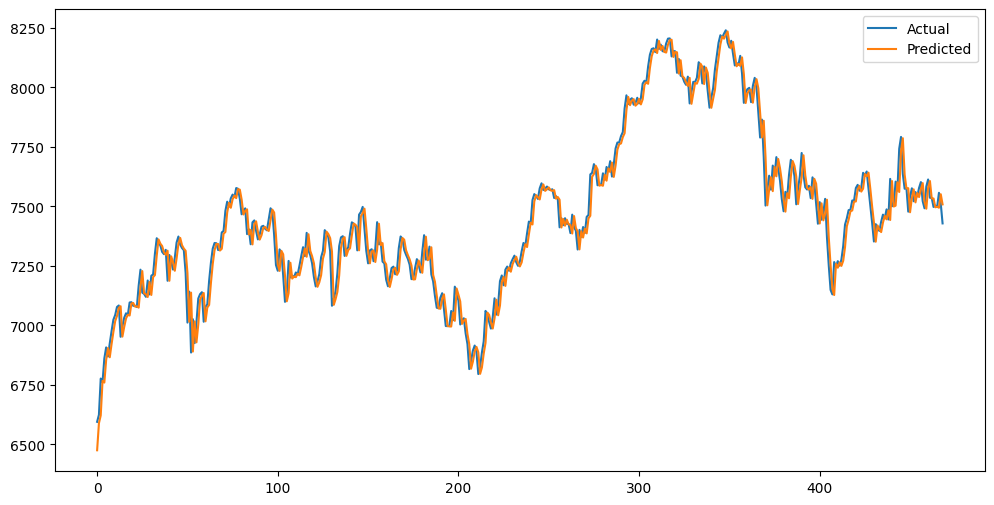

In [41]:
# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.legend()
plt.show()


In [ ]:
rbf_krr_model = KernelRidge(kernel="rbf")
grid_eval = np.logspace(-2, 4, 50)
param_grid = {"alpha": grid_eval, "gamma": grid_eval}
rbf_krr_model_cv = GridSearchCV(rbf_krr_model, param_grid).fit(X_train,y_train)
print(f"Best parameters by CV : {rbf_krr_model_cv.best_params_}")

# Ridge regression using 60 timesteps to predict

We hypothesize that the time series exhibits temporal dependencies, meaning the current value is influenced by the previous observations. Specifically, we assume that the information from the 60 preceding timesteps can be used to predict the next one. To validate this assumption, we will employ a Ridge Regression model, leveraging the past 60 timesteps as features to forecast the next value in the sequence.

In [6]:
def create_lag_features(data, lag):
  x = []
  y = []

  for i in range(lag, len(data)):
      x.append(data[i - lag:i, :])
      y.append(data[i, 0])

  x, y = np.array(x), np.array(y)
  x = np.reshape(x, (x.shape[0], -1))

  assert len(x) == len(y)
  return x, y

def create_dataset(df, feature_cols, lag=10, target="regression", cible="Close"):
    X = df.copy()

    X['Year'] = X['Date'].dt.year
    X['Month'] = X['Date'].dt.month
    X['Day'] = X['Date'].dt.day
    X['Day of Week'] = X['Date'].dt.dayofweek

    #Throw away original date column
    X = X.drop(columns=['Date'])
    year = X['Year']

    #Move target column to first column
    if target == 'regression':
        close = X.pop(cible)
        X.insert(0, cible, close)
    
    #Keep only necessary features
    X = X[feature_cols]

    # Normalize data
    if scaler != None:
        X = scaler.fit_transform(X)
    else:
        X = X.to_numpy()

    #Split into train, test
    train_points = year < 2023
    train_data = X[train_points]

    test_points = year >= 2023
    test_points.iloc[test_points.argmax()-lag:] = True
    test_data = X[test_points]

    X_train, y_train = create_lag_features(train_data, lag)
    X_test, y_test = create_lag_features(test_data, lag)

    return (X_train, y_train), (X_test, y_test)


def next_day(row):
  year, month, day = round(row['Year'].item()), round(row['Month'].item()), round(row['Day'].item())
  new_date = pd.Timestamp(year=year, month=month, day=day)
  new_date += pd.Timedelta(days=3 if int(row['Day of Week'].item()) == 4 else 1)
  return new_date

def dataset_to_df(X, Y, feature_cols,lag=60, cible="Close"):
  if X.ndim == 3:
    last_days = X[:, -1, :]
  elif X.ndim == 2:
    n_feat = int(X.shape[1]/lag)
    last_days = X[:, -n_feat:]
  new_df = pd.DataFrame(last_days, columns=feature_cols)
  #Replace closing price with y and scale back to original values
  new_df[cible] = Y
  if scaler != None:
    new_df = pd.DataFrame(scaler.inverse_transform(new_df), columns=feature_cols)
  #Go to next day (i.e. day of the prediction)
  new_df['Date'] = new_df.apply(next_day, axis=1)
  #Convert name to string
  #new_df["Name"] = name_encoder.inverse_transform(new_df["Name"].to_numpy().reshape(-1, 1))

  return pd.DataFrame(new_df, columns=["Date", cible])

In [ ]:
from tqdm import tqdm
from sklearn.linear_model import  RidgeCV

#Value scaler
scaler = MinMaxScaler(feature_range=(0,1))

import numpy as np

feature_cols = [
                'Close',
                'GDPV', 'IRL', 'IRS', 'GDP', 'CPIH_YTYPCT', 'IRCB', 'UNR',
                'YPH', 'UNR_us', 'CPI_us', 'High_minus_Low', 'Close_minus_Open',
                'SMA_5', 'SMA_10', 'SMA_20', 'WMA_5', 'WMA_10', 'WMA_20', 'Momentum',
                'RSI', 'Williams_R', 'Stochastic_K', 'Stochastic_D', 'CCI', 'MACD',
                'Year', 'Month', 'Day', 'Day of Week'
] # 'IRCB_us'==> na


lag = 60
target = "regression"

#Create dataset
(X_train, y_train), (X_test, y_test) = create_dataset(data, feature_cols,lag=lag, target=target)
#Create model
model = RidgeCV()
#Train model
model.fit(X_train, y_train)


In [11]:

#Make predictions on test set
predicted_prices = model.predict(X_test)
#Convert predictions
pred_df = dataset_to_df(X_test, predicted_prices, lag=lag,feature_cols=feature_cols)
#Get metrics on test set
mse =  mean_squared_error(predicted_prices, y_test)
mae = mean_absolute_error(predicted_prices, y_test)
rmse = mse ** 0.5
r_squared = r2_score(predicted_prices, y_test)

#Make predictions on train set
predicted_prices_test = model.predict(X_train)
#Get metrics on train set
train_mse = mean_squared_error(predicted_prices_test, y_train)
train_mae = mean_absolute_error(predicted_prices_test, y_train)
train_rmse = train_mse ** 0.5
train_r_squared = r2_score(predicted_prices_test, y_train)


In [12]:

# Prepare the data for the summary table
summary_table = {
    "Metric": ["R²", "MSE", "RMSE", "MAE"],
    "Train": [train_r_squared, train_mse, train_rmse, train_mae],
    "Test": [r_squared, mse, rmse, mae]
}

summary_table = pd.DataFrame(summary_table)
print(summary_table)

  Metric     Train      Test
0     R²  0.996960  0.960345
1    MSE  0.000096  0.000133
2   RMSE  0.009809  0.011513
3    MAE  0.007162  0.008959


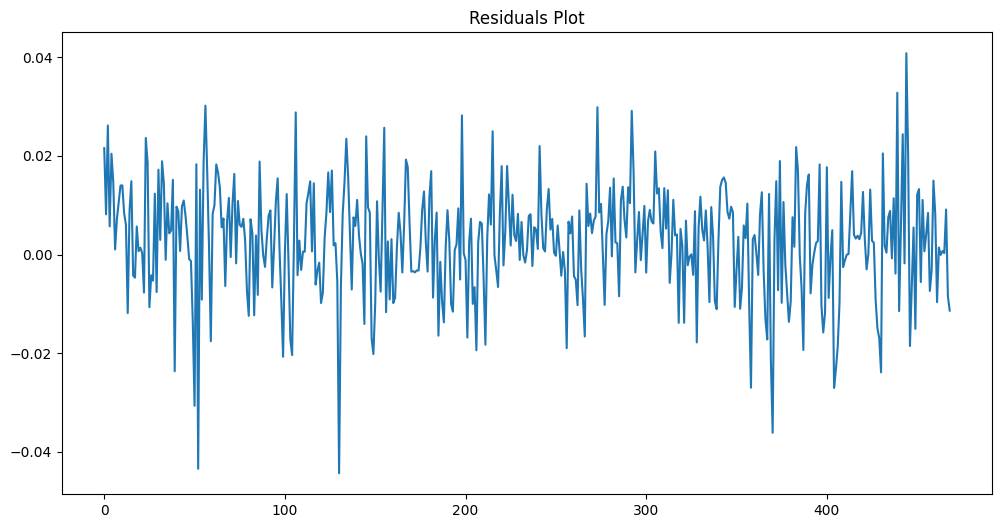

ADF Statistic: -18.535192
p-value: 0.000000


In [15]:
residuals = y_test - predicted_prices

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title("Residuals Plot")
plt.show()


# stationary test
from statsmodels.tsa.stattools import adfuller
result = adfuller(residuals)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


In [14]:
def write_values(rects, ax):
  heights = [r.get_height() for r in rects]
  rel_heights = [h/max(heights) for h in heights]
  idx = heights.index(max(heights))
  for i,(r,h, rh) in enumerate(zip(rects, heights, rel_heights)):
      ax.text(r.get_x() + r.get_width()/2.0, h + max(heights) * .01, f'{h:.2}', ha='center')

def factor_int(n):
  val = math.ceil(math.sqrt(n))
  val2 = int(n/val)
  while val2 * val != float(n):
    val -= 1
    val2 = int(n/val)
  return val, val2

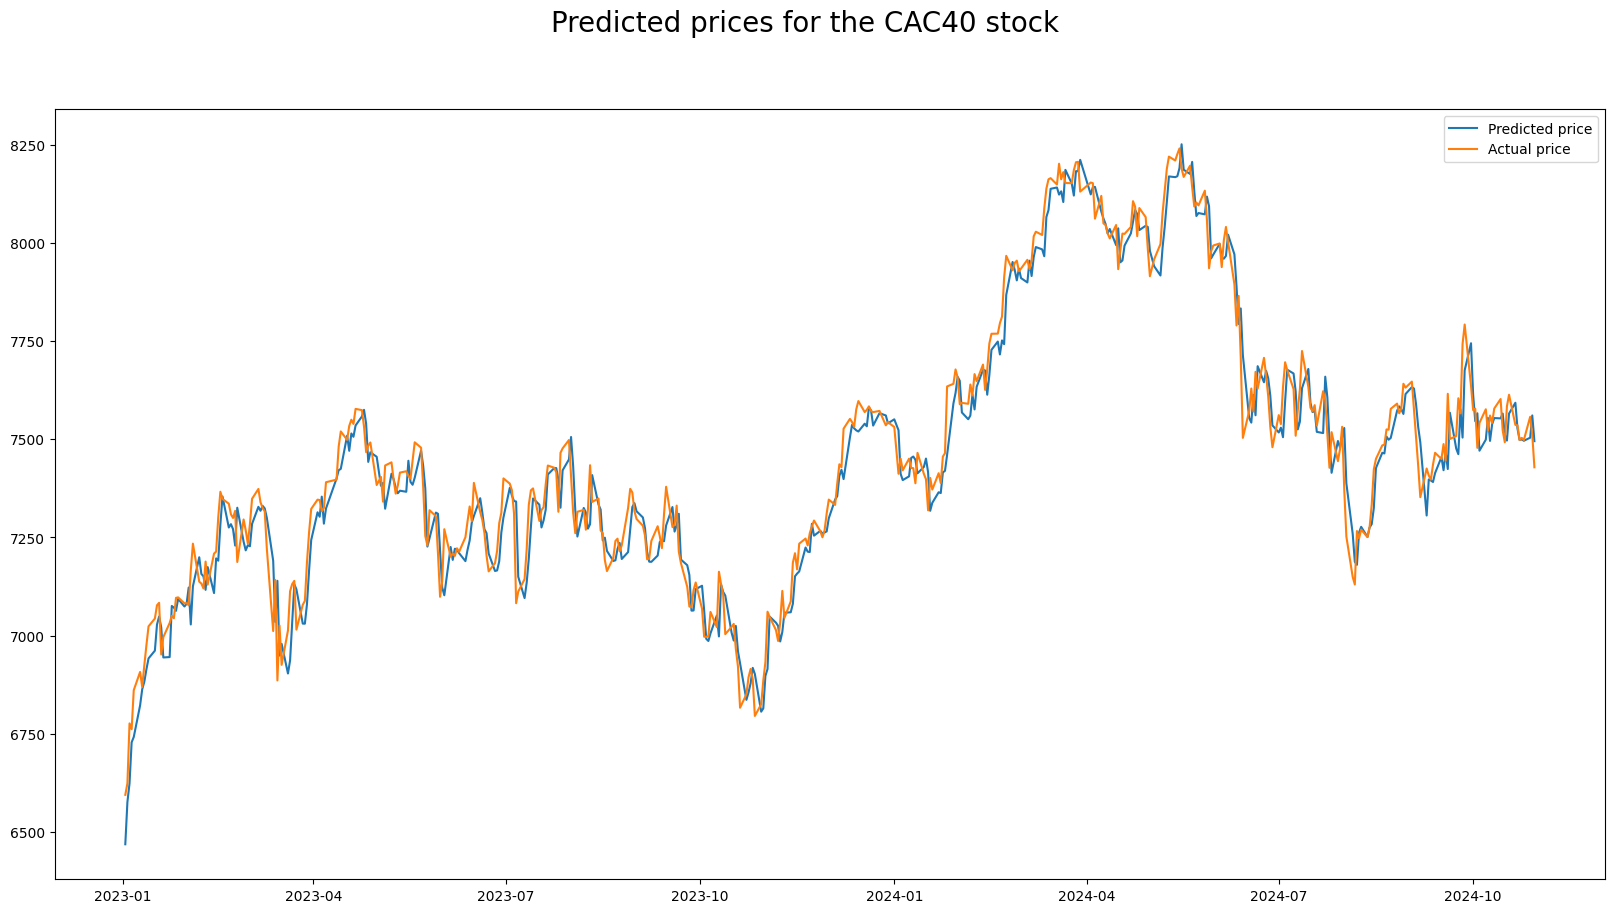

In [19]:
#Line Plot
plt.figure(figsize=(20, 10))

#Get actual prices
real_df = dataset_to_df(X_test, y_test, lag=lag, feature_cols=feature_cols)

#Plot predictions
pred_df = results['pred']
plt.plot(pred_df['Date'], pred_df['Close'], label=f"Predicted price")
#Plot actual prices
plt.plot(real_df['Date'], real_df['Close'], label="Actual price")
#Plot formatting
plt.legend()

#Figure Formatting
plt.suptitle(f'Predicted prices for the CAC40 stock', fontsize = 20)
plt.show()

# Gradient boosting with nadaraya watson

In [20]:
import numpy as np

class GradientBoostingNadarayaWatson:
    def __init__(self, num_iterations=100, learning_rate=0.1, bandwidth=None):
        """
        Gradient Boosting with Nadaraya-Watson Kernel
        
        Args:
        - num_iterations (int): Maximum number of boosting iterations.
        - learning_rate (float): Learning rate for boosting updates.
        - bandwidth (float): Bandwidth for the Nadaraya-Watson kernel. If None, it will be calculated automatically.
        """
        self.num_iterations = num_iterations
        self.learning_rate = learning_rate
        self.bandwidth = bandwidth
        self.F_pred = None
        self.residuals = None
        self.X_train = None

    def _kernel_function(self, x):
        """Epanechnikov kernel function."""
        return np.where(np.abs(x) <= 1, 1/2, 0)

    def _compute_bandwidth(self, n):
        """Calculate bandwidth based on the sample size."""
        return n ** (-1 / 6)

    def _nadaraya_watson(self, x, residuals, X_exp):
        """
        Apply Nadaraya-Watson regression for a single data point `x`.
        
        Args:
        - x: Single data point (1D array) to predict.
        - residuals: Residual values to fit.
        - X_exp: Training features.
        
        Returns:
        - Prediction at x based on kernel regression.
        """
        h = self.bandwidth or self._compute_bandwidth(len(X_exp))
        
        # Compute pairwise distances and kernel weights for multi-dimensional input
        distances = np.linalg.norm((X_exp - x) / h, axis=1)  # Euclidean distance for multi-dimensions
        weights = self._kernel_function(distances)
        
        numerator = np.sum(residuals * weights)
        denominator = np.sum(weights)
        
        return numerator / denominator if denominator != 0 else 0

    def fit(self, X, y):
        """
        Fit the Gradient Boosting with Nadaraya-Watson model.
        
        Args:
        - X (np.array): Training features.
        - y (np.array): Training target values.
        """
        self.X_train = X  # Store the training features
        self.F_pred = np.mean(y)  # Initialize predictions with the mean of y
        
        for _ in range(self.num_iterations):
            # Step 1: Compute residuals
            self.residuals = y - self.F_pred
            
            # Step 2: Fit residuals using Nadaraya-Watson kernel regression
            res_pred = np.array([self._nadaraya_watson(val, self.residuals, self.X_train) for val in self.X_train])
            
            # Step 3: Update model predictions
            self.F_pred += self.learning_rate * res_pred

    def predict(self, X):
        """
        Predict values using the fitted model.
        
        Args:
        - X (np.array): Features for prediction.
        
        Returns:
        - Predictions for the input features.
        """
        if self.F_pred is None or self.residuals is None or self.X_train is None:
            raise ValueError("Model is not fitted yet. Call `fit` before `predict`.")
        
        # Predict using the retained training residuals and features
        predictions = np.array([self._nadaraya_watson(val, self.residuals, self.X_train) for val in X])
        return predictions


In [21]:
# (X_train, y_train), (X_test, y_test) = create_dataset(data, feature_cols,lag=lag, target=target)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

feature_cols = [
                'GDPV', 'IRL', 'IRS', 'GDP', 'CPIH_YTYPCT', 'IRCB', 'UNR',
                'YPH', 'UNR_us',  'CPI_us', 'High_minus_Low', 'Close_minus_Open',
                'SMA_5', 'SMA_10', 'SMA_20', 'WMA_5', 'WMA_10', 'WMA_20', 'Momentum',
                'RSI', 'Williams_R', 'Stochastic_K', 'Stochastic_D', 'CCI', 'MACD',
]

# Select only the columns in `feature_cols` for features
X = data[feature_cols]

# Define the target variable
y = data['Close'].copy()  # Adjust this if your target variable column is named differently
y = y

year = data['Date'].dt.year

X_train =  scaler.fit_transform(X[year < 2023])
X_test = scaler.fit_transform(X[year >= 2023])

y_test = y[year >= 2023].reset_index(drop=True)
y_train = y[year < 2023].reset_index(drop=True)

#Create model
model = GradientBoostingNadarayaWatson(num_iterations=100, learning_rate=0.01)
#Train model
model.fit(X_train, y_train)

In [22]:
# Make predictions on the test set

# Predictions on the train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Performance metrics for the training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_r_squared = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = train_mse ** 0.5

# # Performance metrics for the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_r_squared = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = test_mse ** 0.5

# Prepare the data for the summary table
summary_table = {
    "Metric": ["R²", "MSE", "RMSE", "MAE"],
    "Train": [train_r_squared, train_mse, train_rmse, train_mae],
    "Test": [test_r_squared, test_mse, test_rmse, test_mae]
}

summary_table = pd.DataFrame(summary_table)
print(summary_table)

  Metric         Train          Test
0     R² -1.911064e+01 -4.902235e+02
1    MSE  2.197250e+07  5.573327e+07
2   RMSE  4.687483e+03  7.465472e+03
3    MAE  4.640956e+03  7.457869e+03


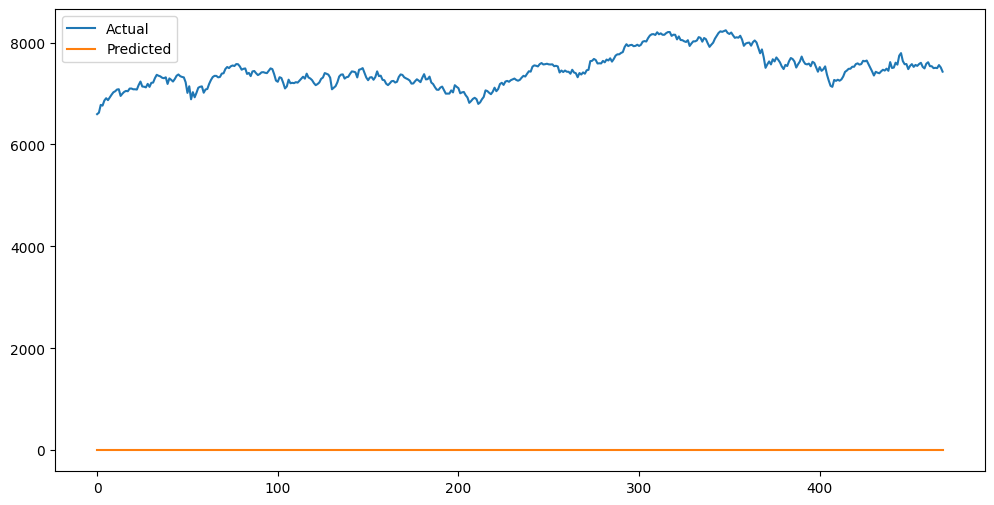

In [23]:
# plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.legend()
plt.show()


In [24]:
from tqdm import tqdm
from sklearn.linear_model import  RidgeCV

#Value scaler
scaler = MinMaxScaler(feature_range=(0,1))

import numpy as np

feature_cols = [
                'Close',
                'GDPV', 'IRL', 'IRS', 'GDP', 'CPIH_YTYPCT', 'IRCB', 'UNR',
                'YPH', 'UNR_us', 'CPI_us', 'High_minus_Low', 'Close_minus_Open',
                'SMA_5', 'SMA_10', 'SMA_20', 'WMA_5', 'WMA_10', 'WMA_20', 'Momentum',
                'RSI', 'Williams_R', 'Stochastic_K', 'Stochastic_D', 'CCI', 'MACD',
                'Year', 'Month', 'Day', 'Day of Week'
] # 'IRCB_us'==> na


lag = 60
target = "regression"

#Create dataset
(X_train, y_train), (X_test, y_test) = create_dataset(data, feature_cols,lag=lag, target=target)
#Create model
model = GradientBoostingNadarayaWatson()
#Train model
model.fit(X_train, y_train)

#Make predictions on test set
predicted_prices = model.predict(X_test)
#Convert predictions
pred_df = dataset_to_df(X_test, predicted_prices, lag=lag,feature_cols=feature_cols)
#Get metrics on test set
mse =  mean_squared_error(predicted_prices, y_test)
mae = mean_absolute_error(predicted_prices, y_test)

#Make predictions on train set
predicted_prices = model.predict(X_train)
#Get metrics on train set
train_mse = mean_squared_error(predicted_prices, y_train)
train_mape = mean_absolute_error(predicted_prices, y_train)

results = {
    "pred" : pred_df,
    "mse" : mse,
    "mape" : mae,
    "train_mse" : train_mse,
    "train_mape" : train_mae
}

KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

class GradientBoostingNadarayaWatson:
    def __init__(self, num_iterations=100, learning_rate=0.1, bandwidth=None, early_stopping_rounds=10):
        """
        Gradient Boosting with Nadaraya-Watson Kernel
        
        Args:
        - num_iterations (int): Maximum number of boosting iterations.
        - learning_rate (float): Learning rate for boosting updates.
        - bandwidth (float): Bandwidth for the Nadaraya-Watson kernel. If None, it will be calculated automatically.
        - early_stopping_rounds (int): Number of iterations to wait for improvement in validation error before stopping.
        """
        self.num_iterations = num_iterations
        self.learning_rate = learning_rate
        self.bandwidth = bandwidth
        self.early_stopping_rounds = early_stopping_rounds
        self.F_pred = None
        self.residuals = None
        self.X_train = None
        self.best_iteration = None
        self.best_val_error = None

    def _kernel_function(self, x):
        """Epanechnikov kernel function."""
        return np.where(np.abs(x) <= 1, 1/2, 0)

    def _compute_bandwidth(self, n):
        """Calculate bandwidth based on the sample size."""
        return n ** (-1 / 6)

    def _nadaraya_watson(self, x, residuals, X_exp):
        """
        Apply Nadaraya-Watson regression for a single data point `x`.
        
        Args:
        - x: Single data point (1D array) to predict.
        - residuals: Residual values to fit.
        - X_exp: Training features.
        
        Returns:
        - Prediction at x based on kernel regression.
        """
        h = self.bandwidth or self._compute_bandwidth(len(X_exp))
        
        # Compute pairwise distances and kernel weights for multi-dimensional input
        distances = np.linalg.norm((X_exp - x) / h, axis=1)  # Euclidean distance for multi-dimensions
        weights = self._kernel_function(distances)
        
        numerator = np.sum(residuals * weights)
        denominator = np.sum(weights)
        
        return numerator / denominator if denominator != 0 else 0

    def fit(self, X, y):
        """
        Fit the Gradient Boosting with Nadaraya-Watson model.
        
        Args:
        - X (np.array): Training features.
        - y (np.array): Training target values.
        """
        # Split data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        self.X_train = X_train  # Store the training features
        self.F_pred = np.mean(y_train)  # Initialize predictions with the mean of y_train
        
        best_val_error = float("inf")
        patience_counter = 0

        for iter_num in range(self.num_iterations):
            # Step 1: Compute residuals
            self.residuals = y_train - self.F_pred
            
            # Step 2: Fit residuals using Nadaraya-Watson kernel regression
            res_pred = np.array([self._nadaraya_watson(val, self.residuals, self.X_train) for val in self.X_train])
            
            # Step 3: Update model predictions
            self.F_pred += self.learning_rate * res_pred
            
            # Step 4: Compute validation error
            val_pred = np.array([self._nadaraya_watson(val, self.residuals, self.X_train) for val in X_val])
            val_error = np.mean((y_val - val_pred) ** 2)  # MSE
            
            # Early stopping logic
            if val_error < best_val_error:
                best_val_error = val_error
                self.best_iteration = iter_num
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.early_stopping_rounds:
                print(f"Early stopping at iteration {iter_num}, best iteration: {self.best_iteration}, best validation error: {best_val_error}")
                break

        self.best_val_error = best_val_error

    def predict(self, X):
        """
        Predict values using the fitted model.
        
        Args:
        - X (np.array): Features for prediction.
        
        Returns:
        - Predictions for the input features.
        """
        if self.F_pred is None or self.residuals is None or self.X_train is None:
            raise ValueError("Model is not fitted yet. Call `fit` before `predict`.")
        
        predictions = np.array([self._nadaraya_watson(val, self.residuals, self.X_train) for val in X])
        return predictions
